# Prerequisites

Please make sure you have the necessary packages installed to run the notebook by
uncommenting the following code block and running it. It is recommended that you first 
set up and activate a virtual environment by running the following commands in your
operating system shell.

```
python -m venv venv
source ./venv/bin/activate  # for Unix-like systems
```

In [1]:
# !pip install -r requirements.txt

# Introduction

SVD, which stands for **S**ingular **V**alue **D**ecomposition,
is one of the most useful tools introduced in linear algebra.
It allows us to __decompose__ a matrix of values into other
__interpretable__ matrices. This enables use cases such as
data reduction and solving systems of linear equations, and serves
as a basis for PCA (which we will not be getting into in
this notebook).

At its core, SVD operates on a data matrix $A$, which can be viewed as an ordered
collection of columns such as $a_1, a_2, \ldots$ and so on.

$$
A = \begin{bmatrix}
\vert & \vert &        & \vert \\
a_1   & a_2   & \cdots & a_n   \\
\vert & \vert &        & \vert \\
\end{bmatrix}
$$

This data matrix's source could be all sorts of objects. As an example, we could vectorize
a collection of face images and use them as the data matrix's columns:

$$
\text{IMG}_1 = 
\begin{bmatrix}
p_{11} & p_{12} & \cdots & p_{1m} \\
p_{21} & p_{22} & \cdots & p_{2m} \\
       &        & \vdots &        \\
p_{n1} & p_{n2} & \cdots & p_{nm}
\end{bmatrix}
\xrightarrow{\text{vectorize}}
\begin{bmatrix}
p_{11} \\
p_{21} \\
\vdots \\
p_{n1} \\
p_{12} \\
p_{22} \\
\vdots \\
p_{n2} \\
\vdots \\
p_{1m} \\
p_{2m} \\
\vdots \\
p_{nm} \\
\end{bmatrix}
$$

So each $a_i$ in this
case would be a single face image's data.

$$
A = \begin{bmatrix}
\vert & \vert &        & \vert \\
\text{IMG}_1   & \text{IMG}_2   & \cdots & \text{IMG}_k   \\
\vert & \vert &        & \vert \\
\end{bmatrix}
$$

Another common source of data matrices could be the different states of a dymanic
system through time.

**But what does SVD do?**

Assuming $A$ is an $m \times n$ matrix, SVD takes the data matrix ($A$) as input,
and decomposes it into **three** different matrices.

$$
A = U \Sigma V^T
$$

$$
\begin{bmatrix}
\vert & \vert &        & \vert \\
a_1   & a_2   & \cdots & a_n   \\
\vert & \vert &        & \vert \\
\end{bmatrix}
= 
\begin{bmatrix}
\vert & \vert &        & \vert \\
u_1   & u_2   & \cdots & u_r   \\
\vert & \vert &        & \vert \\
\end{bmatrix}
\begin{bmatrix}
\sigma_1 & 0        & \cdots & 0 \\
0        & \sigma_2 & \cdots & 0 \\
         &          & \ddots &   \\
0        & 0        & \cdots & \sigma_r
\end{bmatrix}
\begin{bmatrix}
- & v_1    & - \\
- & v_2    & - \\
  & \vdots &   \\
- & v_n    & -
\end{bmatrix}^T
$$

Here,

* $U$ is an $m \times r$ matrix with **orthonormal** columns ($UU^T = I_m$),
* $\Sigma$ is an $r \times r$ **diagonal** matrix, with the values on the digonal being non-negative and sorted in descending order, and
* $V^T$ is an $r \times n$ matrix with **orthonormal** columns ($VV^T = I_n$)

**But what do all these mean?**

> *The decomposed matrices can be used to **describe** the information
> available in the original matrix.*

Assume that each $a_i$ is the data relating to a concept $x$. Then each column
$u_i$ could be interpreted as an **eigen-$x$**. For example, if each $a_i$ was the
image data for a face picture, then each $u_i$ would be an "eigen-face", meaning
that it describes _some feature_ most common in all the available face images in $A$.
These features are **hierarchically arranged**, meaning that $u_1$ describes the most prominent feature between
all the available images, $u_2$ describes the second most prominent, ... and so on.

Each $u_i$ corresponds to a $\sigma_i$, which in turn corresponds to a **row**
in $V^T$, and the relative importance of each feature is described by the corresponding
$\sigma_i$.

* The columns in $U$ are called the **left signular vectors**,
* The columns in $V^T$ are called the **right singular vectors**, and
* The $\Sigma$ matrix's diagonal values contain the **singular values**. 

**Interpreting the results**

Since each vector $u_i$ in the matrix $U$ has the same number of data points (rows)
as the original vectors in $A$, it can be used to reconstruct the concepts in $A$,
but with an emphasis on the prominent features. In the case of face image data,
$u_i$ might reconstruct faces with different aspects of them more visible, such as
nose, eyes, etc.

Each **row** in $V^T$ can be interpreted as a time series of how each feature in $U$
evolves through the different samples in $A$. One could somewhat name them **eigen-timeseries**
if one so wishes.

On the other hand, each **column** in $V^T$ could be viewed as a *mixture* of $u_i$'s to reconstruct
$A$, scaled by the values of $\Sigma$.

> The $U$, $\Sigma$, and $V$ matrices are guaranteed to exist and are unique.

**How can these help with data reduction?**

Since the singular values are ordered by importance, we can **truncate** many of
the singular values that are smaller in magnitude, only keeping the most prominent
features. This technique is known as **calculating the truncated SVD of a matrix**.

## Videos as Matrices

In this project, we wish to learn how we can remove the (static) background of a video
and separate it from the main (dynamic) subject. The main idea here is that a video
is essentially a compilation of images (frames) over time. By placing these images in
a data matrix $A$, we can decompose it using SVD and the most prominent feature of the
data matrix will be the background, as it is common between all/most frames. This method
can be especially useful in real-life scenarios such as interpreting footage from a CCTV
(possibly by a computer).

# Implementation

The implementation consists of the following main steps:

1. Reading the video file and storing it as a multi-dimensional NumPy array
2. (Optional) Converting it to a grayscale image for easier manipulation
3. Creating a data matrix by vectorizing each frame in the video
4. Calculating the truncated SVD; since we are only interested in the most prominent feature (the background)
5. Reconstructing the images from the truncated SVD; this should result in only the background remaining
6. In order to acquire the subjects, we subtract the background matrix from the original

## Data

We will be using a sample CCTV video from a house robbery, displayed below.

(Source: [Two thieves recorded on a security camera](https://mixkit.co/free-stock-video/two-thieves-recorded-on-a-security-camera-31372/))

In [2]:
from IPython.display import Video

In [3]:
Video(filename="data/thieves.mp4", width=400)

## Code

### Extracting Frames

We saw how we can view the video in the previous section, but for us to be able to
turn it into a data matrix, we are going to need to extract each frame from it.
This is accomplished using OpenCV.

In [4]:
import numpy as np
import cv2

In [5]:
def extract_frames(file: str) -> np.ndarray:
    """
    Extract each frame from a video file and
    return as NumPy array.
    """
    # read the video
    video = cv2.VideoCapture(file)

    # extract frames
    frames = []
    while video.isOpened():
        status, frame = video.read()

        # make sure return status was successful
        if not status:
            break

        frames.append(frame)

    video.release()  # close video
    return np.array(frames)

Lets test if the function works correctly.

In [6]:
frames = extract_frames('data/thieves.mp4')
frames.shape

(515, 720, 1280, 3)

The result, as can be seen, is a 4-dimensional array. The first dimension
is the frame itself, the second and third are height and width respectively. The
final dimension is the RGB channel. We can view a single frame to see how it looks
using the `matplotlib` library. As an example, we'll view the 215th frame.

In [7]:
import matplotlib.pyplot as plt

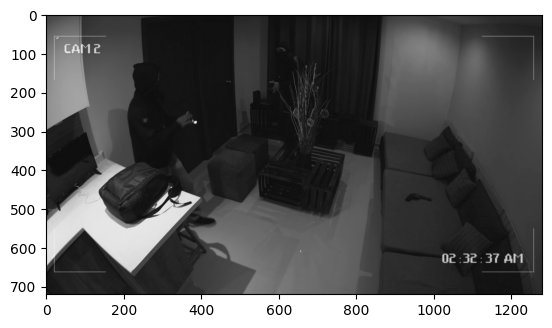

In [8]:
# view a single (random) frame
plt.imshow(frames[215]);

### Converting to Grayscale

However, we don't need the RGB channel, so we
will define a function to convert the entire matrix to grayscale.
This is accomplised by using the
[ITU-R 601-2 luma transform](https://www.sciencedirect.com/topics/computer-science/luma-coefficient):

$$
L = 0.299\,R + 0.587\,G + 0.114\,B
$$

In [9]:
# converting video to grayscale using the ITU-R 601-2 luma transform formula
# L = R * 299/1000 + G * 587/1000 + B * 114/1000
def rgb2gray(rgb: np.ndarray) -> np.ndarray:
    """
    converts an RGB video to grayscale using the ITU-R 601-2 luma transform formula
    L = R * 299/1000 + G * 587/1000 + B * 114/1000
    """
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

Lets put this one to test!

**Note**: It may take a few seconds for the function to finish running.

In [10]:
gray_frames = rgb2gray(frames)

In [11]:
gray_frames.shape

(515, 720, 1280)

We can see that the RGB channel is gone, replaced with a single
luminance dimension.

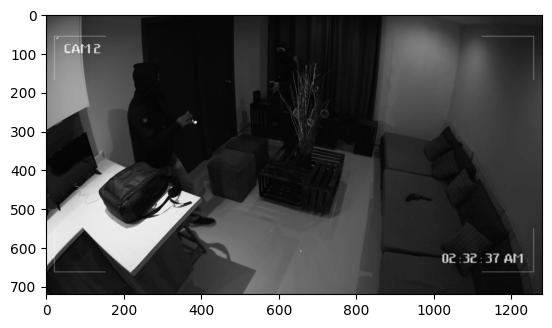

In [12]:
plt.imshow(gray_frames[215], cmap='gray');

### Creating the Data Marix

In [13]:
def create_data_matrix(frames: np.ndarray) -> np.ndarray:
    """
    Create a data matrix from given input.
    """
    A = []
    for frame in gray_frames:
        reshaped_frame = np.reshape(frame, -1)
        A.append(reshaped_frame)

    return np.array(A).T  # frames should be along x-axis

Lets run it on our example and inspect the output.

In [14]:
A = create_data_matrix(gray_frames)

In [15]:
A.shape

(921600, 515)

The x-axis is our frame axis, and each column is essentially a vectorized
image; all pixels stacked on top of each other. So theoretically, the number
of pixels in each frame column should be equal to the resolution of the image;
this is confirmed in the code blocks below.

In [16]:
_, height, width = gray_frames.shape
height, width

(720, 1280)

In [17]:
A.shape[0] == height * width

True

We can also display an image of our data matrix. However, because the 
data matrix is so tall and thin (921600 rows vs 515 columns in this example) it would
not make a very clear image. Instead, we will only display rows 1000 through 3000 of
the data matrix.

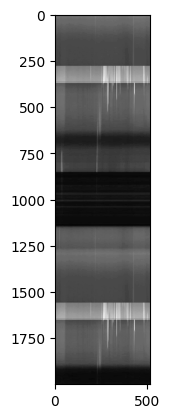

In [18]:
plt.imshow(A[1000:3000], cmap='gray');

We can clearly see a visible pattern in our data matrix. This means that a large number
of columns share the same value in the same rows. The little anomalies that we are seeing 
are actually related to the dynamic foreground.

**Expectation**: SVD should be able to detect these patterns and extract them.
After using SVD and reconstructing the matrix using the most prominent feature,
we expect the anomalies to be gone.

We can also reconstruct a single frame by taking the entire vector for that frame
and reshaping it to the original form. In the demonstration below, we'll use the
250th frame of the video. Any other frame could be reconstructed in the same way.

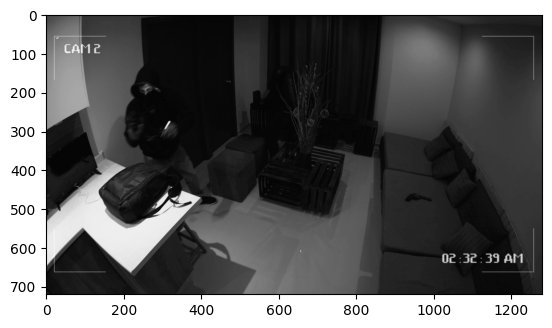

In [19]:
dims = (height, width)
plt.imshow(np.reshape(A[:, 250], dims), cmap='gray');

### Decomposition

Scikit-Learn already provides an efficient implementation of truncated SVD called
`randomized_svd`. Other than the data matrix, it also receives another argument, called
`n_components` which is the number of diagonal elements in the $\Sigma$ matrix ($r$). As
we will only be requiring the single most prominent feature, we will set this parameter to 1.

In [20]:
from sklearn import decomposition

In [21]:
U, S, V = decomposition.randomized_svd(A, n_components=1)

We can confirm that the matrices have the expected shape.

In [22]:
U.shape, S.shape, V.shape

((921600, 1), (1,), (1, 515))

Now, using the (truncated) decomposed matrix, we can reconstruct the original
matrix. The reconstructed matrix will only contain data for the most important
feature; therefore we should expect to only see the background.

In [23]:
# reconstruct matrix using U, S, V
bg = U @ np.diag(S) @ V

In [24]:
bg.shape

(921600, 515)

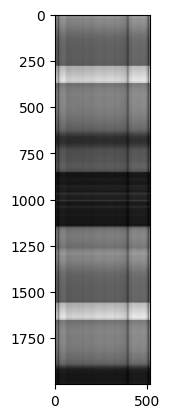

In [25]:
plt.imshow(bg[1000:3000], cmap='gray');

Indeed we can see that the reconstructd data matrix aligns with our
expectations and all anomalies have been removed from it. Lets reconstruct
a random frame from our data matrix to see what it looks like with the thieves
removed from it.

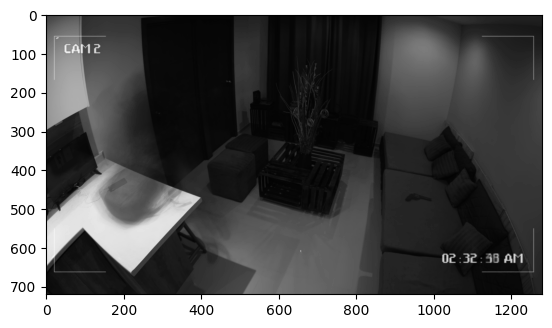

In [26]:
dims = (height, width)
plt.imshow(np.reshape(bg[:, 300], dims), cmap='gray');

We can see that there is some shadowing in the image. The reason for this
is explained a bit further.

The foreground of the video can be acquired by subtracting the background from
the original matrix. As the full subtraction will take some time to run, I will
only demonstrate the subtraction of a single frame.

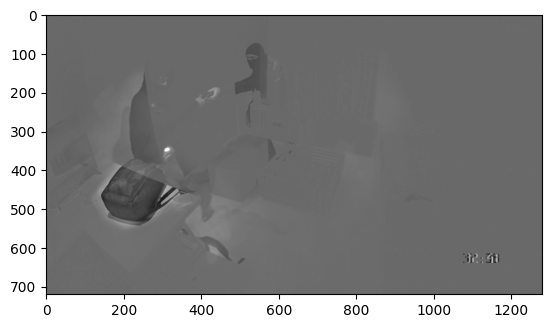

In [27]:
plt.imshow(np.reshape(A[:, 300] - bg[:, 300], dims), cmap='gray');

## Potential Improvements

The division between the background and foreground isn't perfect. Some of the 
reasons for this are described below.

* Currently, the video is short, so creating a data matrix from all of it isn't a really big issue. In a real world scenario, which may contain longer videos, we have to try and rescale the video to a smaller resolution so that the number of rows in the data matrix are decreased. This will allow for much faster processing.
* The current video isn't as long as it could be, and the thieves are mostly occupying the same space. This is why the background detection isn't perfect, and we are seeing some shadowing.
* Another issue that might be causing the distinction between the thieves and background not be as robust as it could be, is the lighting of the environment. In many frames, the thieves blend into the background!
* SVD is a rather simple method of background detection, which assumes a lot about the state of the back- and foreground (static vs. dynamic). A better method is using **Robust PCA** which is of course much more complex.
* In order to keep the code simplistic, the dependencies to a minimum and the project platform-independent, I've refrained from assigning any task to the GPU. In a larger scale project, the GPU can be utilized to speed up a lot of the process.

# References

This notebook took inspiration from the following (awesome!) sources:

- [Data Driven Science and Engineering](https://www.youtube.com/playlist?list=PLMrJAkhIeNNSVjnsviglFoY2nXildDCcv) by Steve Brunton
- [Computational Linear Algebra](https://www.youtube.com/playlist?list=PLtmWHNX-gukIc92m1K0P6bIOnZb-mg0hY) by Rachel Thomas